In [56]:
import requests
import json
from bs4 import BeautifulSoup
import pandas as pd
from collections import defaultdict
import csv
from itertools import permutations
import matplotlib.pyplot as plt
import networkx as nx
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [57]:
df = pd.read_csv('events_2015-2016_pbp.csv')
id_df = pd.read_csv('playerlist.csv')
del id_df['Unnamed: 0']

In [58]:
teams = {'CLE':'Cavaliers', 'TOR':'Raptors', 'MIA':'Heat', 'ATL':'Hawks', 'BOS': 'Celtics', 'CHO':'Hornets',
        'IND':'Pacers', 'DET': 'Pistons', 'CHI':'Bulls', 'WAS':'Wizards','ORL':'Magic', 'NYK':'Knicks',
        'BRK':'Nets', 'GSW':'Warriors', 'SAS':'Spurs', 'OKC':'Thunder', 'LAC':'Clippers', 'POR':'Blazers',
        'DAL':'Mavericks', 'MEM':'Grizzlies', 'HOU':'Rockets', 'UTA':'Jazz', 'SAC':'Kings', 'DEN':'Nuggets', 
        'NOP':'Pelicans', 'MIN':'Timberwolves', 'PHO':'Suns', 'LAL':'Lakers', 'MIL':'Bucks', 'PHI':'76ers'}

In [59]:
df.columns

Index(['Unnamed: 0', 'EVENTMSGACTIONTYPE', 'EVENTMSGTYPE', 'EVENTNUM',
       'GAME_ID', 'HOMEDESCRIPTION', 'NEUTRALDESCRIPTION', 'PCTIMESTRING',
       'PERIOD', 'PERSON1TYPE',
       ...
       'HOME_PLAYER_ID_1_PLAY_TIME', 'HOME_PLAYER_ID_2_PLAY_TIME',
       'HOME_PLAYER_ID_3_PLAY_TIME', 'HOME_PLAYER_ID_4_PLAY_TIME',
       'HOME_PLAYER_ID_5_PLAY_TIME', 'AWAY_PLAYER_ID_1_PLAY_TIME',
       'AWAY_PLAYER_ID_2_PLAY_TIME', 'AWAY_PLAYER_ID_3_PLAY_TIME',
       'AWAY_PLAYER_ID_4_PLAY_TIME', 'AWAY_PLAYER_ID_5_PLAY_TIME'],
      dtype='object', length=111)

In [60]:
id_df.columns

Index(['DISPLAY_FIRST_LAST', 'DISPLAY_LAST_COMMA_FIRST', 'FROM_YEAR',
       'GAMES_PLAYED_FLAG', 'OTHERLEAGUE_EXPERIENCE_CH', 'PERSON_ID',
       'PLAYERCODE', 'ROSTERSTATUS', 'TEAM_ABBREVIATION', 'TEAM_CITY',
       'TEAM_CODE', 'TEAM_ID', 'TEAM_NAME', 'TO_YEAR'],
      dtype='object')

# 1 Game Exploration

In [61]:
subset = df.loc[df.GAME_ID == 21500001]
subset = subset[['GAME_ID','HOMEDESCRIPTION', 'VISITORDESCRIPTION','PCTIMESTRING', 'PERIOD', 'HOME_TEAM', 'AWAY_TEAM',
                'HOME_PLAYER_ID_1','HOME_PLAYER_ID_2', 'HOME_PLAYER_ID_3','HOME_PLAYER_ID_4','HOME_PLAYER_ID_5']]
#              ,'AWAY_PLAYER_ID_1','AWAY_PLAYER_ID_2', 'AWAY_PLAYER_ID_3','AWAY_PLAYER_ID_4','AWAY_PLAYER_ID_5']]

In [62]:
subset['PCTIMESTRING'] = subset['PCTIMESTRING'].str.split(":").apply(lambda x: int(x[0])*60 + int(x[1]))

In [63]:
subs = subset[subset['HOMEDESCRIPTION'].shift(-1).str.contains('SUB', na=False) |
       subset['HOMEDESCRIPTION'].str.contains('SUB', na=False)]
test = subs[~subs['HOMEDESCRIPTION'].str.contains('SUB', na=False)]

### Mutual Play Time
- iterate over rows that come *before sub 
- grab 5 playerids and subtract time from quarter standing
- create edgelist between players


In [64]:
edge_list = []

curr_seconds = 720
curr_period = 1
for row in test.itertuples():
    if row.PERIOD > curr_period:
        curr_period = row.PERIOD 
        curr_seconds = 720 
        
    mutual_time = curr_seconds - row.PCTIMESTRING
    for p1 in range(8,13):
        for p2 in range(p1+1, 13):
            mutual_mins = round((curr_seconds - row.PCTIMESTRING)/60, 2)
            edge_list.append([sorted([row[p1], row[p2]])[0], sorted([row[p1], row[p2]])[1] ,mutual_mins])
#             print([sorted([row[p1], row[p2]])[0], sorted([row[p1], row[p2]])[1] ,mutual_mins])
    curr_seconds = row.PCTIMESTRING

In [65]:
edges = pd.DataFrame(edge_list)
edges.columns =['P1', 'P2', 'MutualTime'] 
edges.groupby(['P1','P2']).sum().reset_index()

,P1,P2,MutualTime
0,2594,200757,5.66
1,2594,200794,17.70
2,2594,201143,15.13
3,2594,201168,5.33
4,2594,201952,20.93
5,2594,203118,3.45
6,2594,203145,14.80
7,2594,203471,6.43
8,2594,203488,6.21
9,200757,200794,12.29


In [66]:
edges['P1'] = edges['P1'].apply(lambda x: id_df.loc[id_df['PERSON_ID'] == x].DISPLAY_FIRST_LAST.item())
edges['P2'] = edges['P2'].apply(lambda x: id_df.loc[id_df['PERSON_ID'] == x].DISPLAY_FIRST_LAST.item())

In [67]:
G=nx.from_pandas_edgelist(edges, 'P1', 'P2', ['MutualTime'])

In [68]:
edge,weights = zip(*nx.get_edge_attributes(G,'MutualTime').items())

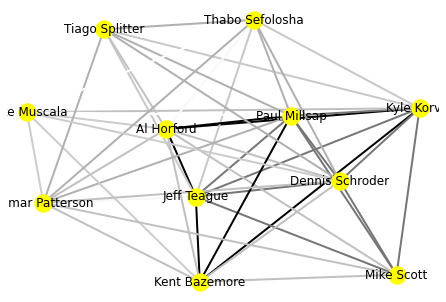

In [69]:
pos = nx.spring_layout(G)
nx.draw(G,with_labels=True, node_color='yellow', edge_color=weights, width=2, edge_cmap=plt.cm.Greys)

# 1 Team Exploration
- Warriors 2016

In [70]:
players = pd.read_csv('NBA_Players_2016.csv')

In [71]:
subset = df.loc[df.HOME_TEAM.str.contains('Warriors') | df.AWAY_TEAM.str.contains('Warriors')]
subset = subset[['GAME_ID','HOMEDESCRIPTION', 'VISITORDESCRIPTION','PCTIMESTRING', 'PERIOD', 'HOME_TEAM', 'AWAY_TEAM',
                'HOME_PLAYER_ID_1','HOME_PLAYER_ID_2', 'HOME_PLAYER_ID_3','HOME_PLAYER_ID_4','HOME_PLAYER_ID_5'
             ,'AWAY_PLAYER_ID_1','AWAY_PLAYER_ID_2', 'AWAY_PLAYER_ID_3','AWAY_PLAYER_ID_4','AWAY_PLAYER_ID_5']]

In [72]:
edge_list = []
nums = 0
for game_id in subset['GAME_ID'].unique():
    boolean = False
    
    subs = subset.loc[df.GAME_ID == game_id]
    pid = subs.iloc[0]['HOME_PLAYER_ID_1']
    name = id_df.loc[id_df['PERSON_ID'] == pid].DISPLAY_FIRST_LAST.item()
    home_teams = list(players.loc[players['name'] == name].team.values) 
    for i in range(len(home_teams)):
        home_teams[i] = teams[home_teams[i]]
    boolean = 'Warriors' in home_teams

    
    if boolean==True:
        new = subs[['HOMEDESCRIPTION', 'PCTIMESTRING', 'PERIOD', 'HOME_TEAM', 'HOME_PLAYER_ID_1',
                         'HOME_PLAYER_ID_2', 'HOME_PLAYER_ID_3', 'HOME_PLAYER_ID_4', 'HOME_PLAYER_ID_5']]
        new['PCTIMESTRING'] = new['PCTIMESTRING'].str.split(":").apply(lambda x: int(x[0])*60 + int(x[1]))
        new = new[new['HOMEDESCRIPTION'].shift(-1).str.contains('SUB', na=False) |
           new['HOMEDESCRIPTION'].str.contains('SUB', na=False)]
        new = new[~new['HOMEDESCRIPTION'].str.contains('SUB', na=False)]
        
        curr_seconds = 720
        curr_period = 1
        for row in new.itertuples():
            if row.PERIOD > curr_period:
                curr_period = row.PERIOD 
                curr_seconds = 720 
            mutual_time = curr_seconds - row.PCTIMESTRING
            for p1 in range(5,9):
                for p2 in range(p1+1, 9):
                    mutual_mins = round((curr_seconds - row.PCTIMESTRING)/60, 2)
                    edge_list.append([sorted([row[p1], row[p2]])[0], sorted([row[p1], row[p2]])[1] ,mutual_mins])
#                     print([sorted([row[p1], row[p2]])[0], sorted([row[p1], row[p2]])[1] ,mutual_mins])
            curr_seconds = row.PCTIMESTRING
#         print('\n')

    else:
        new = subs[['VISITORDESCRIPTION', 'PCTIMESTRING', 'PERIOD', 'AWAY_TEAM', 'AWAY_PLAYER_ID_1',
                         'AWAY_PLAYER_ID_2', 'AWAY_PLAYER_ID_3', 'AWAY_PLAYER_ID_4', 'AWAY_PLAYER_ID_5']]
        new['PCTIMESTRING'] = new['PCTIMESTRING'].str.split(":").apply(lambda x: int(x[0])*60 + int(x[1]))
        new = new[new['VISITORDESCRIPTION'].shift(-1).str.contains('SUB', na=False) |
               new['VISITORDESCRIPTION'].str.contains('SUB', na=False)]
        new = new[~new['VISITORDESCRIPTION'].str.contains('SUB', na=False)]
        
        curr_seconds = 720
        curr_period = 1
        for row in new.itertuples():
            if row.PERIOD > curr_period:
                curr_period = row.PERIOD 
                curr_seconds = 720 
            mutual_time = curr_seconds - row.PCTIMESTRING
            for p1 in range(5,9):
                for p2 in range(p1+1, 9):
                    mutual_mins = round((curr_seconds - row.PCTIMESTRING)/60, 2)
                    edge_list.append([sorted([row[p1], row[p2]])[0], sorted([row[p1], row[p2]])[1] ,mutual_mins])
#                     print([sorted([row[p1], row[p2]])[0], sorted([row[p1], row[p2]])[1] ,mutual_mins])
            curr_seconds = row.PCTIMESTRING
#         print('\n')

In [73]:
edges = pd.DataFrame(edge_list)
edges.columns =['P1', 'P2', 'MutualTime'] 
edges = edges.groupby(['P1','P2']).sum().reset_index()

In [74]:
edges['P1'] = edges['P1'].apply(lambda x: id_df.loc[id_df['PERSON_ID'] == x].DISPLAY_FIRST_LAST.item())
edges['P2'] = edges['P2'].apply(lambda x: id_df.loc[id_df['PERSON_ID'] == x].DISPLAY_FIRST_LAST.item())

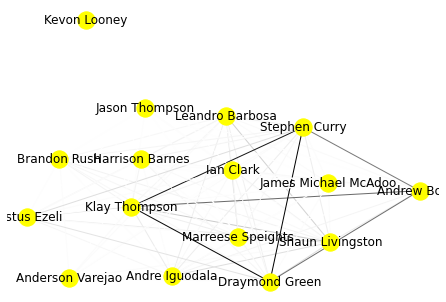

In [75]:
G=nx.from_pandas_edgelist(edges, 'P1', 'P2', ['MutualTime'])
edge,weights = zip(*nx.get_edge_attributes(G,'MutualTime').items())
pos = nx.spring_layout(G)
nx.draw(G,with_labels=True, node_color='yellow', edge_color=weights, width=1, edge_cmap=plt.cm.Greys)

# Creating Script
- Substitute first line (Team Mascot)
- Substitute boolean variable

In [76]:
def create_network(mascot):    
    subset = df.loc[df.HOME_TEAM.str.contains(mascot) | df.AWAY_TEAM.str.contains(mascot)]
    subset = subset[['GAME_ID','HOMEDESCRIPTION', 'VISITORDESCRIPTION','PCTIMESTRING', 'PERIOD', 'HOME_TEAM', 'AWAY_TEAM',
                    'HOME_PLAYER_ID_1','HOME_PLAYER_ID_2', 'HOME_PLAYER_ID_3','HOME_PLAYER_ID_4','HOME_PLAYER_ID_5'
                 ,'AWAY_PLAYER_ID_1','AWAY_PLAYER_ID_2', 'AWAY_PLAYER_ID_3','AWAY_PLAYER_ID_4','AWAY_PLAYER_ID_5']]

    edge_list = []
    nums = 0
    for game_id in subset['GAME_ID'].unique():
        boolean = False

        subs = subset.loc[df.GAME_ID == game_id]
        pid = subs.iloc[0]['HOME_PLAYER_ID_1']
        name = id_df.loc[id_df['PERSON_ID'] == pid].DISPLAY_FIRST_LAST.item()
        home_teams = list(players.loc[players['name'] == name].team.values) 
        for i in range(len(home_teams)):
            home_teams[i] = teams[home_teams[i]]
        boolean = mascot in home_teams

        if boolean==True:
            new = subs[['HOMEDESCRIPTION', 'PCTIMESTRING', 'PERIOD', 'HOME_TEAM', 'HOME_PLAYER_ID_1',
                             'HOME_PLAYER_ID_2', 'HOME_PLAYER_ID_3', 'HOME_PLAYER_ID_4', 'HOME_PLAYER_ID_5']]
            new['PCTIMESTRING'] = new['PCTIMESTRING'].str.split(":").apply(lambda x: int(x[0])*60 + int(x[1]))
            new = new[new['HOMEDESCRIPTION'].shift(-1).str.contains('SUB', na=False) |
               new['HOMEDESCRIPTION'].str.contains('SUB', na=False)]
            new = new[~new['HOMEDESCRIPTION'].str.contains('SUB', na=False)]

            curr_seconds = 720
            curr_period = 1
            for row in new.itertuples():
                if row.PERIOD > curr_period:
                    curr_period = row.PERIOD 
                    curr_seconds = 720 
                mutual_time = curr_seconds - row.PCTIMESTRING
                for p1 in range(5,9):
                    for p2 in range(p1+1, 9):

                        mutual_mins = round((curr_seconds - row.PCTIMESTRING)/60, 2)
                        edge_list.append([sorted([row[p1], row[p2]])[0], sorted([row[p1], row[p2]])[1] ,mutual_mins])
                curr_seconds = row.PCTIMESTRING

        else:
            new = subs[['VISITORDESCRIPTION', 'PCTIMESTRING', 'PERIOD', 'AWAY_TEAM', 'AWAY_PLAYER_ID_1',
                             'AWAY_PLAYER_ID_2', 'AWAY_PLAYER_ID_3', 'AWAY_PLAYER_ID_4', 'AWAY_PLAYER_ID_5']]
            new['PCTIMESTRING'] = new['PCTIMESTRING'].str.split(":").apply(lambda x: int(x[0])*60 + int(x[1]))
            new = new[new['VISITORDESCRIPTION'].shift(-1).str.contains('SUB', na=False) |
                   new['VISITORDESCRIPTION'].str.contains('SUB', na=False)]
            new = new[~new['VISITORDESCRIPTION'].str.contains('SUB', na=False)]

            curr_seconds = 720
            curr_period = 1
            for row in new.itertuples():
                if row.PERIOD > curr_period:
                    curr_period = row.PERIOD 
                    curr_seconds = 720 
                mutual_time = curr_seconds - row.PCTIMESTRING
                for p1 in range(5,9):
                    for p2 in range(p1+1, 9):
                        mutual_mins = round((curr_seconds - row.PCTIMESTRING)/60, 2)
                        edge_list.append([sorted([row[p1], row[p2]])[0], sorted([row[p1], row[p2]])[1] ,mutual_mins])
                curr_seconds = row.PCTIMESTRING

    edges = pd.DataFrame(edge_list)
    edges.columns =['P1', 'P2', 'MutualTime'] 
    edges = edges.groupby(['P1','P2']).sum().reset_index()
    edges['P1'] = edges['P1'].apply(lambda x: id_df.loc[id_df['PERSON_ID'] == x].DISPLAY_FIRST_LAST.item())
    edges['P2'] = edges['P2'].apply(lambda x: id_df.loc[id_df['PERSON_ID'] == x].DISPLAY_FIRST_LAST.item())

    G=nx.from_pandas_edgelist(edges, 'P1', 'P2', ['MutualTime'])
    edge,weights = zip(*nx.get_edge_attributes(G,'MutualTime').items())
    
    return G

In [77]:
warriors = create_network('Warriors')

In [78]:
print(nx.info(warriors))

Name: 
Type: Graph
Number of nodes: 16
Number of edges: 107
Average degree:  13.3750


In [79]:
with open ('NBA_Players_2016.csv', 'r') as nodecsv:
    nodereader = csv.reader(nodecsv)
    nodes = [n for n in nodereader][1:]

In [80]:
node_names = [n[0] for n in nodes]

In [81]:
team_dict = {}
year_dict = {}
ppg_dict = {}
apg_dict = {}
rpg_dict = {}
three_point_percentage_dict = {}
two_point_percentage_dict = {}
mp_dict = {}
gp_dict = {}

for node in nodes:
    team_dict[node[0]] = node[1]
    year_dict[node[0]] = node[2]
    ppg_dict[node[0]] = node[3]
    apg_dict[node[0]] = node[4]
    rpg_dict[node[0]] = node[5]
    three_point_percentage_dict[node[0]] = node[6]
    two_point_percentage_dict[node[0]] = node[7]
    mp_dict[node[0]] = node[8]
    gp_dict[node[0]] = node[9]
    
nx.set_node_attributes(warriors, team_dict, 'team')
nx.set_node_attributes(warriors, year_dict, 'year')
nx.set_node_attributes(warriors, ppg_dict, 'ppg')
nx.set_node_attributes(warriors, apg_dict, 'apg')
nx.set_node_attributes(warriors, rpg_dict, 'rpg')
nx.set_node_attributes(warriors, three_point_percentage_dict, '3P%')
nx.set_node_attributes(warriors, two_point_percentage_dict, '2P%')
nx.set_node_attributes(warriors, mp_dict, 'mp')
nx.set_node_attributes(warriors, gp_dict, 'gp')


In [82]:
for n in warriors.nodes():
    try:
#         print(n, warriors.nodes[n]['ppg'], warriors.nodes[n]['apg'], warriors.nodes[n]['rpg'] )
        print(n, warriors.nodes[n])
    except:
        pass

Leandro Barbosa {'team': 'GSW', 'year': '2016', 'ppg': '6.4', 'apg': '1.2', 'rpg': '1.7', '3P%': '.355', '2P%': '.508', 'mp': '15.9', 'gp': '68'}
Shaun Livingston {'team': 'GSW', 'year': '2016', 'ppg': '6.3', 'apg': '3.0', 'rpg': '2.2', '3P%': '.167', '2P%': '.548', 'mp': '19.5', 'gp': '78'}
Andre Iguodala {'team': 'GSW', 'year': '2016', 'ppg': '7.0', 'apg': '3.4', 'rpg': '4.0', '3P%': '.351', '2P%': '.570', 'mp': '26.6', 'gp': '65'}
Anderson Varejao {}
Andrew Bogut {'team': 'GSW', 'year': '2016', 'ppg': '5.4', 'apg': '2.3', 'rpg': '7.0', '3P%': '1.000', '2P%': '.626', 'mp': '20.7', 'gp': '70'}
Jason Thompson {'team': 'GSW', 'year': '2016', 'ppg': '2.1', 'apg': '0.7', 'rpg': '1.9', '3P%': '', '2P%': '.476', 'mp': '6.4', 'gp': '28'}
Brandon Rush {'team': 'GSW', 'year': '2016', 'ppg': '4.2', 'apg': '0.8', 'rpg': '2.5', '3P%': '.414', '2P%': '.447', 'mp': '14.7', 'gp': '72'}
Marreese Speights {'team': 'GSW', 'year': '2016', 'ppg': '7.1', 'apg': '0.8', 'rpg': '3.3', '3P%': '.387', '2P%': '

### GCN

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx

In [ ]:
numEpochs = 25
learningRate = 0.01

In [ ]:
# Define the GCNLayer module
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first set the node features
        g.ndata['h'] = inputs
        # trigger message passing on all edges
        g.send(g.edges(), gcn_message)
        # trigger aggregation at all nodes
        g.recv(g.nodes(), gcn_reduce)
        # get the result node features
        h = g.ndata.pop('h')
        # perform linear transformation
        return self.linear(h)

# Define a 2-layer GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_size)
        self.gcn2 = GCNLayer(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        return h

### GraphSage

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms

In [56]:
class SupervisedGraphSage(nn.Module):
    def __init__(self, num_classes, enc):
        super(SupervisedGraphSage, self).__init__()
        self.enc = enc
        self.xent = nn.CrossEntropyLoss()

        self.weight = nn.Parameter(torch.FloatTensor(num_classes, enc.embed_dim))
        init.xavier_uniform(self.weight)

    def forward(self, nodes):
        embeds = self.enc(nodes)
        scores = self.weight.mm(embeds)
        return scores.t()

    def loss(self, nodes, labels):
        scores = self.forward(nodes)
        return self.xent(scores, labels.squeeze())